In [72]:
import argparse

def args_parser():
    parser = argparse.ArgumentParser()
    # federated arguments
    #RL的训练轮次
    parser.add_argument('--epochs', type=int, default=500, help="rounds of training")
    
    #嵌入向量的训练轮次
    parser.add_argument('--emb_train_epochs', type=int, default=5, help="rounds of training")
    parser.add_argument('--emb', default=True)
    
    #验证RL和Fedavg哪个更好的验证轮次
    parser.add_argument('--validation_epochs', type=int, default=50, help="rounds of training")
    parser.add_argument('--divide', default=True)
    parser.add_argument('--reset_flag', type=int, default=20, help="reset flag")
    
    #将训练集分为几份
    parser.add_argument('--divide_num', type=int, default=2, help="divide number")
    
    #有多少个local client
    parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
    parser.add_argument('--k', type=int, default=10, help="k")
    
    #每次选多少个local client参与训练
    parser.add_argument('--frac', type=float, default=0.1, help="the fraction of clients: C")
    parser.add_argument('--train_frac', type=float, default=1, help="the fraction of training: C")
    
    parser.add_argument('--collect_ep', type=int, default=1000, help="rounds of training")
    
    #local client自己本地训练的轮次
    parser.add_argument('--local_emb_ep', type=int, default=1, help="the number of local epochs: E")
    parser.add_argument('--local_ep', type=int, default=1, help="the number of local epochs: E")
    parser.add_argument('--local_chosen_ep', type=int, default=2, help="the number of local epochs: E")
    
    #验证环节的local clinet本地训练轮次
    parser.add_argument('--local_validation_ep', type=int, default=1, help="the number of local epochs: E")
    
    #local client本地训练的batchsize
    parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
    parser.add_argument('--bs', type=int, default=128, help="test batch size")
    
    #RL的学习率和衰减率
    parser.add_argument('--lr', type=float, default=0.01, help="learning rate (default: 0.01)")
    parser.add_argument('--lr_decay', type=float, default=1, help="lr decay")
    parser.add_argument('--momentum', type=float, default=0.5, help="SGD momentum (default: 0.5)")
    parser.add_argument('--split', type=str, default='user', help="train-test split type, user or sample")

    # model arguments
    
    #使用的client 模型
    parser.add_argument('--model', type=str, default='cnn', help='model name')
    parser.add_argument('--kernel_num', type=int, default=9, help='number of each kind of kernel')
    parser.add_argument('--kernel_sizes', type=str, default='3,4,5',
                        help='comma-separated kernel size to use for convolution')
    parser.add_argument('--norm', type=str, default='batch_norm', help="batch_norm, layer_norm, or None")
    parser.add_argument('--num_filters', type=int, default=32, help="number of filters for conv nets")
    parser.add_argument('--max_pool', type=str, default='True',
                        help="Whether use max pooling rather than strided convolutions")

    # other arguments
    
    #使用的数据集
    parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset")
    
    #数据集的划分是否满足独立同分布
    parser.add_argument('--iid', action='store_true', help='whether i.i.d or not')
    
    #输出的分类个数
    parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
    
    #输入的图片的通道数
    parser.add_argument('--num_channels', type=int, default=1, help="number of channels of imges")
    parser.add_argument('--gpu', type=int, default=-1, help="GPU ID, -1 for CPU")
    parser.add_argument('--stopping_rounds', type=int, default=10, help='rounds of early stopping')
    parser.add_argument('--verbose', action='store_true', help='verbose print')
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    parser.add_argument('--all_clients', action='store_true', help='aggregation over all clients')
    args = parser.parse_args(args=[])
    return args

In [73]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
import random
from torchvision import datasets, transforms
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, mnist_iid_drl_local_divide, cifar_iid_drl_local_divide, mnist_noniid_drl_local_divide
from models.Update import LocalUpdate
from models.Update_divide import LocalUpdate_divide
from models.Nets import MLP, CNNMnist, CNNCifar, CNNCifarEmb, CNNCifarEmbReverse, CNNMnistEmb, CNNMnistEmbReverse
from models.Fed import FedAvg
# from models.test import test_img

# parse args
args = args_parser()
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(1,1,1))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=False, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    args.iid = False
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    args.iid = True
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

CNNMnist(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import heapq
from torch.autograd import Variable

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.95             # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency

class Net(nn.Module):

    def __init__(self, parameter_dim, action_dim, args):
        super(Net, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.action_dim = action_dim

        # N+1 即global的p拼接上所有local的p
        self.fc1 = nn.Linear(parameter_dim, 1000)
        self.fc2 = nn.Linear(1000, action_dim)

    def forward(self, parameters):
        #拼接的p
        x = self.fc1(parameters)
        q = self.fc2(x)
        
        #100维
        return q

class DQN(object):
    def __init__(self, parameter_dim, action_dim, replay_buffer, args):
        self.parameter_dim = parameter_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.args = args
        self.iter = 0
        #self.noise = utils.OrnsteinUhlenbeckActionNoise(self.action_dim)

        self.eval_net = Net(self.parameter_dim,  
                                 self.action_dim, args).to(args.device)
        self.target_net = Net(self.parameter_dim, 
                                 self.action_dim, args).to(args.device)

        self.learn_step_counter = 0                                     # for target updating
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), 0.01)
#         self.loss_func = F.smooth_l1_loss
         
    #选q最大的local，直接赋值给global，只用一个local参与训练的目的是加快训练
    def choose_action_train(self, parameters):
        q = self.eval_net.forward(parameters)
        action = q.detach().numpy()[0][0].tolist().index(max(q.detach().numpy()[0][0]))
        #这是索引
        print(action)
        return action
    
    #选q最大的10个local，再将它们的q用softmax变成权值
    def choose_action_run(self, parameters):
        q = self.eval_net.forward(parameters)
        #l是q的列表形式
        l = q.detach().numpy()[0][0].tolist()
        
        #最大的k个q值
        topk = heapq.nlargest(int(self.args.frac * self.args.num_users), l)
        
        #找索引
        choice = []
        for i in topk:
            choice.append(l.index(i))
        
        #算权值
        topk_sum = np.sum(topk)
        for i in range(len(topk)):
            topk[i] /= topk_sum
        action = topk
        
        #softmax
#         action = F.softmax(topk)
        print(choice)
        return choice, action

    def optimize(self):
        """
        Samples a random batch from replay memory and performs optimization
        :return:
        """
        s1,a1,r1,s2 = self.replay_buffer.sample(10)
#         print(s1)
#         print(a1)
#         print(r1)
        s1 = Variable(s1, requires_grad=True)
        r1 = Variable(r1, requires_grad=True)
        s2 = Variable(s2, requires_grad=True)
        
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net.forward(s1) # shape (batch, 1)
#         a = Variable(torch.from_numpy(np.array([a1]))).type(torch.LongTensor)
#         q_eval = q_eval.gather(0,a).squeeze()
        a1 = a1.tolist()    
        q_eval_list = q_eval.tolist()[0]
        q_eval = []
        for i in range(len(q_eval_list)):
            q = 0
            for j in range(len(a1[i])):
                q += q_eval_list[i][int(a1[i][j])]/10000
            q_eval.append([q/len(a1[i])])
        q_eval = torch.Tensor(q_eval)
#         print(q_eval)
        
        
        q_next = self.eval_net.forward(s2).detach()     # detach from graph, don't backpropagate
#         print(q_next)
        q_next_list = q_next.tolist()[0]
        a_next = []
        for i in range(len(q_next_list)):
            a = []
            topk = heapq.nlargest(int(self.args.frac * self.args.num_users), q_next_list[i])
            for j in range(len(topk)):
                tmp = q_next_list[i].index(topk[j])
                a.append(tmp)
            a_next.append(a)
        
        q_target_next = self.target_net(s2).detach()
        q_target_next_list = q_target_next.tolist()[0]
        q_target_next = []
        for i in range(len(q_target_next_list)):
            q = 0
            for j in range(len(a_next[i])):
                q += q_target_next_list[i][a_next[i][j]]/10000
            q_target_next.append([q/len(a_next[i])])
        q_target_next = torch.Tensor(q_target_next)
#         print(q_target_next)
        
        q_target = r1 + GAMMA * q_target_next  # shape (batch, 1)
        loss = F.smooth_l1_loss(q_eval.float(), q_target.float())

        
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
#         self.soft_update(self.target_net, self.eval_net, 0.001)        

In [75]:
# from torch.autograd import Variable
# x = torch.Tensor(range(10))
# print(F.softmax(x,0))
# a = Variable(torch.from_numpy(np.array([5]))).type(torch.LongTensor)
# print(a)
# print(a.unsqueeze(1))
# x.gather(0,a).squeeze()

In [76]:
class MemoryBuffer: # MemoryBuffer类实现的功能：buffer内采样，往buffer里塞（sars）

    def __init__(self, size):
        self.buffer = deque(maxlen=size) #buffer设置为双端队列
        self.maxSize = size
        self.len = 0
        
    def state_reco(self, s):
        s_1 = [i[0] for i in s]
        s_2 = [i[1] for i in s]
        s_3 = [i[2] for i in s]
        return [torch.cat(s_1),torch.cat(s_2),torch.cat(s_3)]

    def sample(self, count):
        """
        samples a random batch from the replay memory buffer
        :param count: batch size
        :return: batch (numpy array)
        """
        batch = []
        count = min(count, self.len)
        batch = random.sample(self.buffer, count) # 随机取样

        s_arr = torch.cat([arr[0] for arr in batch],1)
        a_arr = torch.tensor([arr[1] for arr in batch])
        r_arr = torch.tensor([arr[2] for arr in batch]).reshape(-1,1)
        s1_arr = torch.cat([arr[3] for arr in batch],1)

        return s_arr, a_arr, r_arr, s1_arr

    def len(self):
        return self.len

    def add(self, s, a, r, s1):
        """
        adds a particular transaction in the memory buffer
        :param s: current state
        :param a: action taken
        :param r: reward received
        :param s1: next state
        :return:
        """
        reset_flag = 40
        add_count = 0
        transition = (s,a,r,s1)
        self.len += 1
        if self.len > self.maxSize:
            self.len = self.maxSize
        self.buffer.append(transition)
        add_count += 1
        if add_count == reset_flag:
            self.buffer = deque(maxlen=size)
            add_count = 0

In [77]:
#每个local的每一层在emb之后拼接起来，再乘以(100+1)，或者用均值。分别对应是400和100
parameter_dim = (args.num_users+1) * 100
action_dim = args.num_users
print(parameter_dim)

10100


In [78]:
layer_dict = {}
layer_name = []
count = 0
for name in w_glob.keys():
    if count % 2 == 0:
        layer_name.append(name.split('.',1)[0])
    count += 1
    
for i in layer_name:
#     layer_dict[i] = CNNCifarEmb(torch.cat([w_glob[i+'.weight'].reshape(1,-1), w_glob[i+'.bias'].reshape(1,-1)], 1).numel())
    layer_dict[i] = CNNMnistEmb(torch.cat([w_glob[i+'.weight'].reshape(1,-1), w_glob[i+'.bias'].reshape(1,-1)], 1).numel())
# emb_reverse = CNNCifarEmbReverse(args)
emb_reverse = CNNMnistEmbReverse(args)
# print(w_glob[i+'.weight'].reshape(1,-1).numpy()[0])

# print(w_glob[i+'.bias'].numpy())

optimizer = torch.optim.Adam([
    {'params':layer_dict[layer_name[0]].parameters()},
    {'params':layer_dict[layer_name[1]].parameters()},
    {'params':layer_dict[layer_name[2]].parameters()},
    {'params':layer_dict[layer_name[3]].parameters()},
#     {'params':layer_dict[layer_name[4]].parameters()},
    {'params':emb_reverse.parameters()}
] ,0.01)

for iter in range(args.emb_train_epochs):
    idxs_users = np.random.choice(range(args.num_users), 100, replace=False)
    
    for idx in idxs_users:
#         local = LocalUpdate_divide(args=args, dataset=dataset_train, idxs=dict_users[0][idx])
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
#         w, loss, loss_list = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1).to(args.device))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1).to(args.device))
        avg_emb_feature = emb_feature/4
        transform_w = emb_reverse.forward(avg_emb_feature)
        loss_w = [sum((w[i].reshape(1,-1) - transform_w[i].reshape(1,-1)) ** 2) for i in w_glob.keys()]
        loss_avg = 0
        loss_check_dict = {}
        for i in range(len(loss_w)):
            loss_avg += sum(loss_w[i])/len(loss_w[i])
            loss_check_dict[len(loss_w[i])] = loss_w[i]
            if loss_avg.item() > 3.0:
                print('len:{},w:{}'.format(len(loss_w[i]), loss_check_dict[len(loss_w[i])]))
                print('loss_sum:', loss_avg)
                print('\n***************')
        optimizer.zero_grad()
        loss_avg.backward(retain_graph=True)
        optimizer.step()
        print('epoch:{}, loss_avg:{}'.format(iter, loss_avg))

epoch:0, loss_avg:0.14283256232738495
epoch:0, loss_avg:0.4421205520629883
epoch:0, loss_avg:0.1828140765428543
epoch:0, loss_avg:0.2194962501525879
epoch:0, loss_avg:0.167791485786438
epoch:0, loss_avg:0.11470726877450943
epoch:0, loss_avg:0.21228577196598053
epoch:0, loss_avg:0.8082790970802307
epoch:0, loss_avg:0.4383396506309509
epoch:0, loss_avg:0.19843563437461853
epoch:0, loss_avg:0.17731745541095734
epoch:0, loss_avg:0.05347681790590286
epoch:0, loss_avg:0.06839808076620102
epoch:0, loss_avg:0.05507805198431015
epoch:0, loss_avg:0.061597757041454315
epoch:0, loss_avg:0.04792385920882225
epoch:0, loss_avg:0.06587247550487518
epoch:0, loss_avg:0.06981831043958664
epoch:0, loss_avg:0.0743120014667511
epoch:0, loss_avg:0.09482083469629288
epoch:0, loss_avg:0.06391963362693787
epoch:0, loss_avg:0.06765797734260559
epoch:0, loss_avg:0.0837058424949646
epoch:0, loss_avg:0.08891676366329193
epoch:0, loss_avg:0.05015251040458679
epoch:0, loss_avg:0.051111020147800446
epoch:0, loss_avg:0

epoch:2, loss_avg:0.051041267812252045
epoch:2, loss_avg:0.07095755636692047
epoch:2, loss_avg:0.050460733473300934
epoch:2, loss_avg:0.05117597430944443
epoch:2, loss_avg:0.047284651547670364
epoch:2, loss_avg:0.06193218007683754
epoch:2, loss_avg:0.055474042892456055
epoch:2, loss_avg:0.17277973890304565
epoch:2, loss_avg:0.06996461004018784
epoch:2, loss_avg:0.08037039637565613
epoch:2, loss_avg:0.05788422375917435
epoch:2, loss_avg:0.07382740080356598
epoch:2, loss_avg:0.04799604415893555
epoch:2, loss_avg:0.08644312620162964
epoch:2, loss_avg:0.05461160093545914
epoch:2, loss_avg:0.06022743880748749
epoch:2, loss_avg:0.056088145822286606
epoch:2, loss_avg:0.08590653538703918
epoch:2, loss_avg:0.04962471127510071
epoch:2, loss_avg:0.06538254022598267
epoch:2, loss_avg:0.07595651596784592
epoch:2, loss_avg:0.045967407524585724
epoch:2, loss_avg:0.04919493570923805
epoch:2, loss_avg:0.06039029359817505
epoch:2, loss_avg:0.05546789988875389
epoch:2, loss_avg:0.3128584921360016
epoch:2

epoch:4, loss_avg:0.04793037474155426
epoch:4, loss_avg:0.045182205736637115
epoch:4, loss_avg:0.06341404467821121
epoch:4, loss_avg:0.06898858398199081
epoch:4, loss_avg:0.04478355497121811
epoch:4, loss_avg:0.047496844083070755
epoch:4, loss_avg:0.044594429433345795
epoch:4, loss_avg:0.05144903063774109
epoch:4, loss_avg:0.06877158582210541
epoch:4, loss_avg:0.06309758126735687
epoch:4, loss_avg:0.07231319695711136
epoch:4, loss_avg:0.05683460831642151
epoch:4, loss_avg:0.06333325803279877
epoch:4, loss_avg:0.05965851992368698
epoch:4, loss_avg:0.074168361723423
epoch:4, loss_avg:0.04958617687225342
epoch:4, loss_avg:0.04804511368274689
epoch:4, loss_avg:0.08997024595737457
epoch:4, loss_avg:0.05051504820585251
epoch:4, loss_avg:0.06816818565130234
epoch:4, loss_avg:0.04373011738061905
epoch:4, loss_avg:0.0604417622089386
epoch:4, loss_avg:0.05788732320070267
epoch:4, loss_avg:0.048131126910448074
epoch:4, loss_avg:0.048563435673713684
epoch:4, loss_avg:0.06841757148504257
epoch:4, l

In [79]:
replay_buffer = MemoryBuffer(20)
dqn = DQN(parameter_dim, action_dim, replay_buffer, args)

In [80]:
def FedPareto(w, action, choice):
    w_chosen = []
    for i in choice:
        w_chosen.append(w[i])
    w_avg = copy.deepcopy(w_chosen[0])
    for k in w_avg.keys():
        for i in range(0, len(w_chosen)):
            if i==0:
                w_avg[k] = action[i] * w_chosen[i][k]
            else:
                w_avg[k] += action[i] * w_chosen[i][k]
    return w_avg

In [81]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

def test_img(net_g, datatest, args):
    net_g.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=args.bs)
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        if args.gpu != -1:
            data, target = data, target
        log_probs = net_g(data)
        # sum up batch loss
        test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    if args.verbose:
        print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss

In [ ]:
# training rl

#先全部训练一次，然后找topk个客户端，用q来算权值。之后把global发送给所有local，开启第二轮训练。被选中的客户端训练两次，其他的训练一次。


loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

loss_save = []
m = max(int(args.frac * args.num_users), 1)
constant = 2
target_acc = 0.99
args.emb = False
# dqn = torch.load('doubledqn_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))
# dqn = torch.load('dqn_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))

last_replay_data = []
for iter in range(args.epochs):
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n<args.num_users*args.frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n+=1
        action = random.sample(range(0,100),10)

    #重置global参数    
    if iter % args.reset_flag == 0:
        if args.model == 'cnn' and args.dataset == 'cifar':
            net_glob = CNNCifar(args=args).to(args.device)
        elif args.model == 'cnn' and args.dataset == 'mnist':
            net_glob = CNNMnist(args=args).to(args.device)
        elif args.model == 'mlp':
            len_in = 1
            for x in img_size:
                len_in *= x
            net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
        else:
            exit('Error: unrecognized model')
        
        
    loss_locals = []
    w_locals = []
    p_emb_collect = []
    for i in layer_name:
        if i == 'conv1':
            emb_global = layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
        else:
            emb_global += layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
    p_emb_collect.append(emb_global)
    
    for idx in range(100):
        if idx in action:
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx], flag=True)
        else:
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
#         if loss != 0:
#             print('local loss:', loss)
        #把parameter转成嵌入
        
        ##########  求均值方式  #######
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
        
        #分母对应local网络的层数
        avg_emb_feature = emb_feature/4
        
        ##########  拼接方式  ##########
#         for i in layer_name:
#             if i == 'conv1':
#                 cat_emb = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
#             else:
#                 cat_emb = torch.cat([cat_emb, layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))], 1)
                
        ############ 储存嵌入 ##############
        p_emb_collect.append(avg_emb_feature)
        ############ 储存参数 ##############
        w_locals.append(copy.deepcopy(w))
    p_emb_collect = torch.cat(p_emb_collect,1).unsqueeze(0).to(args.device)
#     print(p_emb_collect)
    choice, action_next = dqn.choose_action_run(p_emb_collect)
    
    ###########  计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中    
    net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_train, args)
    print(global_acc)
    reward = constant ** (global_acc.numpy()/100 - target_acc) - 1
    loss_save.append(reward)
    
    if len(last_replay_data)==2:
        last_replay_data.append(reward)#r
        last_replay_data.append(p_emb_collect)#s_next
        dqn.replay_buffer.add(last_replay_data[0], last_replay_data[1], last_replay_data[2], last_replay_data[3])
    
    last_replay_data = [p_emb_collect, choice]#s, a
    action = choice
    
    # update global weights
#     w_glob = FedAvg(w_locals)
#     w_glob = FedPareto(w_locals, action_next)
    
    # copy weight to net_glob
#     net_glob.train()
#     net_glob.load_state_dict(w_locals[action])
    
    #ours
    w_glob = FedPareto(w_locals, action_next, choice)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
    
    
    # print loss
    print('Round {:3d}, Average loss {:.3f}'.format(iter, reward))
#     loss_train.append(-reward)
    
    if iter > 0:
        dqn.optimize()
    if iter % 10 == 0:
#         torch.save(dqn, 'dqn_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))
        torch.save(dqn, 'doubledqn_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))
        print("saved")
#     args.lr = max(args.lr*args.lr_decay, 0.001)


[30, 85, 11, 24, 62, 36, 66, 57, 64, 87]
tensor(9.7367)
Round   0, Average loss -0.461
saved
[66, 85, 62, 36, 30, 24, 47, 53, 77, 88]
tensor(10.4417)
Round   1, Average loss -0.459
[66, 36, 24, 62, 47, 85, 53, 92, 11, 30]
tensor(10.7350)
Round   2, Average loss -0.458
[66, 47, 85, 30, 53, 62, 36, 43, 61, 24]
tensor(21.0883)
Round   3, Average loss -0.417
[66, 85, 24, 30, 43, 47, 36, 53, 62, 11]
tensor(25.3050)
Round   4, Average loss -0.400
[47, 24, 66, 30, 85, 62, 36, 53, 96, 88]
tensor(26.6317)
Round   5, Average loss -0.394
[24, 85, 47, 66, 62, 53, 36, 30, 96, 38]
tensor(27.6483)
Round   6, Average loss -0.390
[85, 24, 47, 62, 53, 66, 30, 36, 88, 61]
tensor(25.5983)
Round   7, Average loss -0.399
[24, 66, 85, 47, 62, 53, 36, 30, 61, 96]
tensor(27.3900)
Round   8, Average loss -0.391
[24, 47, 53, 85, 66, 38, 36, 62, 61, 88]
tensor(28.4300)
Round   9, Average loss -0.387
[24, 62, 66, 85, 36, 88, 47, 11, 61, 30]
tensor(27.9617)
Round  10, Average loss -0.389
saved
[24, 47, 36, 66, 85, 

tensor(27.3483)
Round  92, Average loss -0.391
[24, 47, 30, 36, 85, 61, 53, 66, 38, 62]
tensor(26.5350)
Round  93, Average loss -0.395
[24, 85, 30, 47, 62, 36, 11, 38, 66, 53]
tensor(32.6217)
Round  94, Average loss -0.369
[24, 47, 66, 36, 53, 62, 85, 30, 11, 96]
tensor(29.2183)
Round  95, Average loss -0.383
[24, 85, 66, 47, 53, 36, 62, 30, 96, 11]
tensor(27.8900)
Round  96, Average loss -0.389
[24, 85, 66, 47, 30, 36, 53, 38, 62, 61]
tensor(27.5883)
Round  97, Average loss -0.390
[24, 62, 85, 47, 88, 30, 36, 48, 66, 53]
tensor(28.2567)
Round  98, Average loss -0.388
[24, 85, 66, 47, 62, 30, 36, 61, 53, 88]
tensor(31.8017)
Round  99, Average loss -0.372
[30, 66, 87, 85, 47, 91, 57, 88, 79, 24]
tensor(9.9150)
Round 100, Average loss -0.461
saved
[47, 85, 43, 36, 62, 24, 66, 68, 30, 69]
tensor(9.9150)
Round 101, Average loss -0.461
[24, 66, 85, 47, 30, 62, 36, 53, 11, 38]
tensor(18.2350)
Round 102, Average loss -0.429
[24, 30, 85, 66, 62, 36, 47, 88, 61, 43]
tensor(24.1083)
Round 103, A

In [57]:
torch.save(dqn, 'doubledqn_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))

In [69]:
# fl
#initialize
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
net_glob.train()
w_glob = net_glob.state_dict()


m = max(int(args.frac * args.num_users), 1)
# dqn = torch.load('doubledqn_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))
constant = 2
target_acc = 0.98
for iter in range(args.validation_epochs):
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n<args.num_users*args.frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n+=1
        l = list(range(0,100))
        action = random.sample(l, m)
      
    loss_locals = []
    w_locals = []
    p_emb_collect = []
    choice = []
    
    for i in layer_name:
        if i == 'conv1':
            emb_global = layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
        else:
            emb_global += layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
    p_emb_collect.append(emb_global)
    
    for idx in range(100):
        if idx in choice:
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx], flag=True)
        else:
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        
        #把parameter转成嵌入
        
        ##########  求均值方式  #######
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
        
        #分母对应local网络的层数
        avg_emb_feature = emb_feature/4
        
        
        ##########  拼接方式  ##########
        for i in layer_name:
            if i == 'conv1':
                cat_emb = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
            else:
                cat_emb = torch.cat([cat_emb, layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))], 1)
                
        ############ 储存嵌入 ##############
        p_emb_collect.append(avg_emb_feature)
        
        ############ 储存参数 ##############
        w_locals.append(copy.deepcopy(w))
        
    p_emb_collect = torch.cat(p_emb_collect,1).unsqueeze(0).to(args.device)
    choice, action_next = dqn.choose_action_run(p_emb_collect)
    
    ###########  计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中    
#     net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_train, args)
    reward = constant ** (global_acc.numpy()/100 - target_acc) - 1

    action = action_next
    
    # update global weights
    #fedavg
#     chosen_w = []
#     for i in choice:
#         chosen_w.append(w_locals[i])
#     w_glob = FedAvg(chosen_w)
    
    #ours
    w_glob = FedPareto(w_locals, action_next, choice)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
    
    # print loss
    print('Round {:3d}, Average loss {:.3f}'.format(iter, -reward))
#     loss_train.append(-reward)

#     args.lr = max(args.lr*args.lr_decay, 0.001)

[42, 64, 74, 54, 82, 45, 25, 11, 55, 98]
Round   0, Average loss 0.463
[74, 82, 42, 64, 72, 98, 11, 70, 45, 46]
Round   1, Average loss 0.457
[74, 82, 45, 98, 64, 42, 70, 97, 11, 72]
Round   2, Average loss 0.157
[74, 42, 82, 98, 46, 72, 45, 11, 70, 33]
Round   3, Average loss 0.098
[74, 82, 42, 11, 98, 46, 64, 70, 72, 95]
Round   4, Average loss 0.077
[74, 42, 82, 64, 30, 98, 11, 72, 70, 46]
Round   5, Average loss 0.061
[74, 64, 70, 11, 45, 30, 72, 42, 82, 46]
Round   6, Average loss 0.049
[74, 64, 82, 42, 98, 30, 11, 46, 86, 45]
Round   7, Average loss 0.042
[74, 82, 42, 98, 11, 64, 46, 45, 54, 30]
Round   8, Average loss 0.036
[74, 64, 42, 98, 82, 11, 30, 46, 45, 70]
Round   9, Average loss 0.036


In [70]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

def test_img(net_g, datatest, args):
    net_g.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=args.bs)
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        if args.gpu != -1:
            data, target = data, target
        log_probs = net_g(data)
        # sum up batch loss
        test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    if args.verbose:
        print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss

In [71]:
# plot loss curve
# plt.figure()
# plt.plot(range(len(loss_train)), loss_train)
# plt.ylabel('train_loss')
# plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

# testing
net_glob.eval()
acc_train, loss_train = test_img(net_glob, dataset_train, args)
acc_test, loss_test = test_img(net_glob, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))

Training accuracy: 93.33
Testing accuracy: 93.81


In [ ]:
loss_train

In [ ]:
loss_save

<function matplotlib.pyplot.show(*args, **kw)>

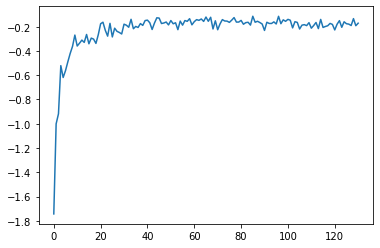

In [77]:
%matplotlib inline

plt.plot(range(len(loss_save)), loss_save)
plt.show